In [ ]:
# 필요한 package 불러오기

%pylab inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## (1) LOF (Local Outlier Factor) Algorithm

In [ ]:
# Gnerated dataset

np.random.seed(2)

dim = 2 # number of dimensions of dataset = 2
# cluster of normal random variable moderately dense
data1 = np.random.multivariate_normal([0, 1500], [[100000, 0], [0, 100000]], 2000)

# very dense
data2 = np.random.multivariate_normal([2000, 0], [[10000, 0], [0, 10000]], 2500)

# sparse
data3 = np.random.multivariate_normal([2500, 2500], [[100000, 0], [0, 100000]], 500)

# mix the three dataset and shuffle
data = np.vstack((np.vstack((data1, data2)), data3))
np.random.shuffle(data)

# add some noise : zipf is skewed distribution and can have extreme values(outliers)
zipf_alpha = 2.25
noise = np.random.zipf(zipf_alpha, (5000,dim)) * np.sign((np.random.randint(2, size = (5000, dim)) - 0.5))
data += noise

In [ ]:
data.shape

(5000, 2)

> Distance 정의

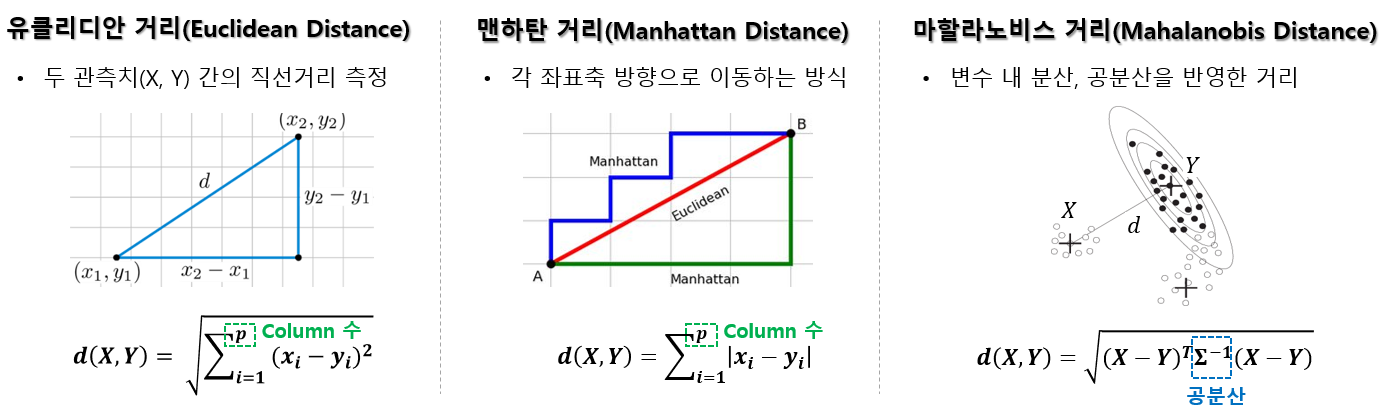

In [ ]:
 # distance between points (Euclidean)

tic = time.time()
dist = DistanceMetric.get_metric('euclidean').pairwise(data)
print('++ took %g msecs for Distance computation' %  ((time.time() - tic)* 1000))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  category=FutureWarning,


++ took 423.499 msecs for Distance computation


In [ ]:
dist.shape # 총 5000개 samples 간의 거리 계산

(5000, 5000)

> Radius

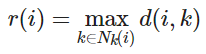

In [ ]:
tic = time.time()
k = 17 # number of neighbors to consider

# get the radius for each point in dataset (distance to kth nearest neighbor)
# radius is the distance of kth nearest point for each point in dataset        
idx_knn = np.argsort(dist, axis=1)[:,1 : k + 1] # by row' get k nearest neighbour   
radius = np.linalg.norm(data - data[idx_knn[:, -1]], axis = 1) # radius
print('+++ took %g msecs for KNN Querying' %  ((time.time() - tic)* 1000))

+++ took 2033.91 msecs for KNN Querying


In [ ]:
idx_knn

array([[3821, 2053,  802, ..., 4812, 2925, 2368],
       [3539, 4283, 2241, ..., 2605,  613, 3128],
       [ 399, 4606, 2213, ..., 1237, 2135, 2344],
       ...,
       [ 666, 3912,   49, ..., 1551, 4531, 4410],
       [ 327, 4270, 3340, ..., 4099, 3880, 4118],
       [3025, 2198, 1708, ..., 2836, 2055, 3366]])

In [ ]:
radius

array([52.53851961, 28.08261004, 22.55848815, ..., 12.93692865,
       48.51320503, 44.8090923 ])

In [ ]:
print(idx_knn.shape)
print(radius.shape)

(5000, 17)
(5000,)


> Reach distance (rd) & Local Reachability Distance (LRD)

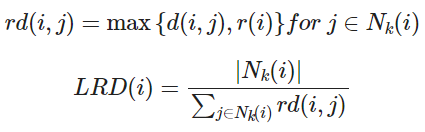

In [ ]:
# calculate the local reachability density
tic = time.time()
LRD = []
for i in range(idx_knn.shape[0]):
    LRD.append(np.mean(np.maximum(dist[i, idx_knn[i]], radius[idx_knn[i]])))

print('++++ took %g msecs for LRD computation' %  ((time.time() - tic)* 1000))

++++ took 96.7395 msecs for LRD computation


> Local Outlier Factor (LOF)

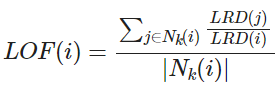

In [ ]:
# calculating the outlier score
tic = time.time()
rho = 1. / np.array(LRD) # inverse of density
outlier_score = np.sum(rho[idx_knn], axis = 1)/ np.array(rho, dtype = np.float16)
outlier_score *= 1./k
print('+++++ took %g msecs for Outlier scoring' %  ((time.time() - tic)* 1000))

+++++ took 10.6366 msecs for Outlier scoring


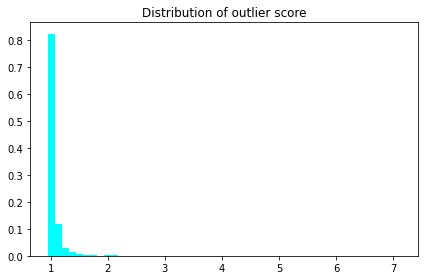

In [ ]:
# the histogram of Outlier score, to choose the optimal threshold to decid weather a data-point is outlier is not.
# the optimal outlier score threshold to decide weather a data-point is outlier is outlier or not is around 2 for most of the cases

weights = np.ones_like(outlier_score)/outlier_score.shape[0] # to normalize the histogram to probability plot
plt.hist(outlier_score, bins = 50, weights = weights, histtype = 'stepfilled', color = 'cyan')
plt.title('Distribution of outlier score')
plt.tight_layout()
plt.show()

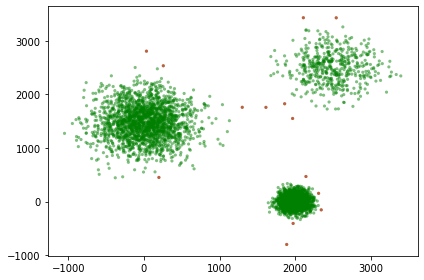

In [ ]:
threshold = 2.

# plot non outliers as green
plt.scatter(data[:, 0], data[:, 1], c = 'green', s = 10, edgecolors='None', alpha=0.5)

# find the outliers and plot te outliers
idx = np.where(outlier_score > threshold)
plt.scatter(data[idx, 0], data[idx, 1], c = 'red', s = 10, edgecolors='None', alpha=0.5)
plt.tight_layout()
plt.show()

## (2) Anomaly Detection with LOF

In [ ]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0708.git

Cloning into 'DX-Training-LGES-0708'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [ ]:
# load the dataset

data= pd.read_csv("/content/DX-Training-LGES-0708/Data/CTG.csv")
data.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,9.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,1.0


In [ ]:
data = data.dropna()
data.shape

(2126, 33)

In [ ]:
X=data.iloc[:, :-1] # input variables
y=data.iloc[:, -1] # target variables

In [ ]:
# Principal Component Analysis (PCA) to reduce the dimension 

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

In [ ]:
# fit the model for outlier detection 
# use the default value of 20 nearest neighbors to measure the local deviation of the density

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [ ]:
# use fit_predict to compute the predicted labels of the training samples

y_pred = clf.fit_predict(X_pca)
n_errors = (y_pred != y).sum()
X_scores = clf.negative_outlier_factor_

In [ ]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
pd.DataFrame(y_pred)[0].value_counts() # -1: outliers

 1    1913
-1     213
Name: 0, dtype: int64

In [ ]:
n_errors

601

In [ ]:
X_scores

array([-1.10989839, -1.00758086, -1.00749347, ..., -0.96695581,
       -0.9949099 , -0.99458377])

In [ ]:
results = pd.concat([pd.DataFrame(y_pred)[0], pd.DataFrame(X_scores)[0]], axis=1)
results.columns = ['Pred', 'LOF Scores']
results

,Pred,LOF Scores
0,1,-1.109898
1,1,-1.007581
2,1,-1.007493
3,1,-0.945407
4,1,-0.991346
...,...,...
2121,1,-1.008887
2122,1,-0.979128
2123,1,-0.966956
2124,1,-0.994910


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


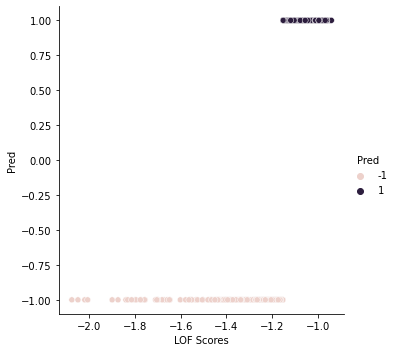

In [ ]:
# visualize the LOF scroes
# if a data point has a substantially lower density than its neighbors, then the data point is considered as an outlier.

sns.relplot('LOF Scores' , 'Pred', hue = 'Pred', data = results)

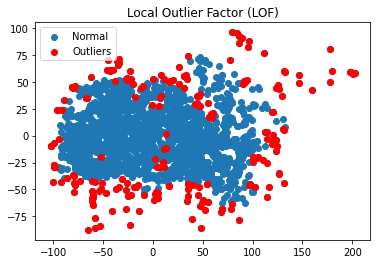

In [ ]:
# Visualize the outliers using matplotlib, where the LOF score is not 1.

lofs_index = np.where(y_pred!=1)
values = X_pca[lofs_index]
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_pca[:,0], X_pca[:,1], label="Normal")
plt.scatter(values[:,0],values[:,1], color='r', label="Outliers")
plt.legend(loc="upper left")
plt.show()